In [4]:
#@title Copyright 2023 The Earth Engine Community Authors { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Species Distribution Modeling
Author: Byeong-Hyeok Yu

In this tutorial, the methodology of Species Distribution Modeling using Google Earth Engine will be introduced. A brief overview of Species Distribution Modeling  will be provided, followed by the process of predicting and analyzing the habitat of an endangered bird species known as the Fairy pitta (scientific name: *Pitta nympha*).

### Run me first

Run the following cell to initialize the API. The output will contain instructions on how to grant this notebook access to Earth Engine using your account.

In [1]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
# ee.Initialize(project='my-project')
ee.Initialize(project='ee-foss4g')

## A brief overview of Species Distribution Modeling

Let's explore what species distribution models are, the advantages of using Google Earth Engine for their processing, the required data for the models, and how the workflow is structured.

### What is Species Distribution Modeling?

Species Distribution Modeling (SDM below) is the most common methodology used to estimate the actual or potential geographic distribution of a species. It involves characterizing the environmental conditions suitable for a particular species and then identifying where these suitable conditions are distributed geographically.

SDM has emerged as a crucial component of conservation planning in recent years, and various modeling techniques have been developed for this purpose. Implementing SDM in Google Earth Engine (GEE below) provides easy access to large-scale environmental data, along with powerful computing capabilities and support for machine learning algorithms, allowing for rapid modeling.

  > Note: Conservation biologist Dr. Ramiro D. Crego implemented SDM using the GEE JavaScript Code Editor and published his research findings [(Crego et al, 2022)](https://onlinelibrary.wiley.com/doi/10.1111/ddi.13491). The methodology of SDM introduced here has been translated and modified from the [JavaScript source code](https://smithsonian.github.io/SDMinGEE/) he shared into the Python language.

### Data Required for SDM

SDM typically utilizes the relationship between known species occurrence records and environmental variables to identify the conditions under which a population can sustain. In other words, two types of model input data are required:

1. Occurrence records of known species
1. Various environmental variables

These data are input into algorithms to identify environmental conditions associated with the presence of species.

### Workflow of SDM using GEE

The workflow for SDM using GEE is as follows:

1. Collection and preprocessing of species occurrence data
1. Definition of the area of interest
1. Addition of GEE environmental variables
1. Generation of pseudo-absence data
1. Model fitting and prediction
1. Variable importance and accuracy assessment

## Habitat Prediction and Analysis Using GEE

The [Fairy pitta (*Pitta nympha*)](https://datazone.birdlife.org/species/factsheet/22698684) will be used as a case study to demonstrate the application of GEE-based SDM. While this specific species has been selected for one example, researchers can apply the methodology to any target species of interest with slight modifications to the provided source code.

The Fairy pitta is a rare summer migrant and passage migrant in South Korea, whose distribution area is expanding due to recent climate warming on the Korean Peninsula. It is classified as a rare species, endangered wildlife of class II, Natural Monument No. 204, evaluated as Regionally Extinct (RE) in the National Red List, and Vulnerable (VU) according to the IUCN categories.

Conducting SDM for the conservation planning of the Fairy pitta appears to be quite valuable. Now, let's proceed with habitat prediction and analysis through GEE.

First, the Python libraries are imported.The `import` statement brings in the entire contents of a module, while the `from import` statement allows for the importation of specific objects from a module.

In [3]:
# Import libraries
import geemap

import geemap.colormaps as cm
import pandas as pd, geopandas as gpd
import numpy as np, matplotlib.pyplot as plt
import os, requests, math, random

from ipyleaflet import TileLayer
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Collection and Preprocessing of Species Occurrence Data

Now, let's collect occurrence data for the Fairy pitta. Even if you don't currently have access to occurrence data for the species of interest, you can obtain observational data about specific species through the GBIF API. The [GBIF API](https://techdocs.gbif.org/en/openapi/) is an interface that allows access to the species distribution data provided by GBIF, enabling users to search, filter, and download data, as well as acquire various information related to species.

In the code below, the `species_name` variable is assigned the scientific name of the species (e.g. *Pitta nympha* for Fairy pitta), and the `country_code` variable is assigned the country code (e.g. KR for South Korea). The `base_url` variable stores the address of the GBIF API. `params` is a dictionary containing parameters to be used in the API request:

* `scientificName`: Sets the scientific name of the species to be searched.
* `country`: Limits the search to a specific country.
* `hasCoordinate`: Ensures only data with coordinates (true) are searched.
* `basisOfRecord`: Chooses only records of human observation (`HUMAN_OBSERVATION`).
* `limit`: Sets the maximum number of results returned to 10000.

In [6]:
def get_gbif_species_data(species_name, country_code):
    """
    Retrieves observational data for a specific species using the GBIF API and returns it as a pandas DataFrame.

    Parameters:
    species_name (str): The scientific name of the species to query.
    country_code (str): The country code of the where the observation data will be queried.

    Returns:
    pd.DataFrame: A pandas DataFrame containing the observational data.
    """
    base_url = "https://api.gbif.org/v1/occurrence/search"
    params = {
        "scientificName": species_name,
        "country": country_code,
        "hasCoordinate": "true",
        "basisOfRecord": "HUMAN_OBSERVATION",
        "limit": 10000,
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Raises an exception for a response error.
        data = response.json()
        occurrences = data.get("results", [])

        if occurrences:  # If data is present
            df = pd.json_normalize(occurrences)
            return df
        else:
            print("No data found for the given species and country code.")
            return pd.DataFrame()  # Returns an empty DataFrame
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        return pd.DataFrame()  # Returns an empty DataFrame in case of an exception

Using the parameters set previously, we query the GBIF API for observational records of the Fairy pitta (*Pitta nympha*), and load the results into a DataFrame to check the first row. A DataFrame is a data structure for handling table-formatted data, consisting of rows and columns. If necessary, the DataFrame can be saved as a CSV file and read back in.

In [8]:
# Retrieve Fairy Pitta data
df = get_gbif_species_data("Pitta nympha", "KR")
"""
# Save DataFrame to CSV and read back in.
df.to_csv("pitta_nympha_data.csv", index=False)
df = pd.read_csv("pitta_nympha_data.csv")
"""
df.head(1)  # Display the first row of the DataFrame

,key,datasetKey,publishingOrgKey,installationKey,hostingOrganizationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,...,nomenclaturalCode,fieldNotes,behavior,verbatimElevation,higherClassification,extensions.http://rs.tdwg.org/ac/terms/Multimedia,distanceFromCentroidInMeters,associatedTaxa,lifeStage,occurrenceRemarks
0,4126765284,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,28eb1a3f-1c15-4a95-931a-4af90ecb574d,US,DWC_ARCHIVE,2024-01-23T16:28:21.693+00:00,2024-01-25T09:13:47.069+00:00,431,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next, we convert the DataFrame into a GeoDataFrame that includes a column for geographic information (`geometry`) and check the first row. A GeoDataFrame can be saved as a GeoPackage file (*.gpkg) and read back in.

In [9]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.decimalLongitude,
                                df.decimalLatitude),
    crs="EPSG:4326"
)[["species", "year", "month", "geometry"]]
"""
# Convert GeoDataFrame to GeoPackage (requires pycrs module)
%pip install -U -q pycrs
gdf.to_file("pitta_nympha_data.gpkg", driver="GPKG")
gdf = gpd.read_file("pitta_nympha_data.gpkg")
"""
gdf.head(1)  # Display the first row of the GeoDataFrame

,species,year,month,geometry
0,Pitta nympha,2023,5,POINT (126.72514 33.20314)


This time, we have created a function to visualize the distribution of data by year and month from the GeoDataFrame and display it as a graph, which can then be saved as an image file. This allows for the identification of temporal patterns and seasonal variations in species occurrence data, as well as the rapid detection of outliers or quality issues within the data.

In [10]:
# Visualize the distribution of data by year and month
def plot_data_distribution(gdf, h_size=12):

    plt.figure(figsize=(h_size, h_size-8))

    # Yearly data distribution graph (left)
    plt.subplot(1, 2, 1)
    year_counts = gdf['year'].value_counts().sort_index()
    plt.bar(year_counts.index, year_counts.values)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Yearly Data Distribution')

    # Display data counts above the bars
    for i, count in enumerate(year_counts.values):
        plt.text(year_counts.index[i], count, str(count), ha='center', va='bottom')

    # Monthly data distribution graph (right)
    plt.subplot(1, 2, 2)
    month_counts = gdf['month'].value_counts().sort_index()
    plt.bar(month_counts.index, month_counts.values)
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.title('Monthly Data Distribution')

    # Display data counts above the bars
    for i, count in enumerate(month_counts.values):
        plt.text(month_counts.index[i], count, str(count), ha='center', va='bottom')

    # Set x-axis ticks as integers
    plt.xticks(month_counts.index, map(int, month_counts.index))

    # Output the graph
    plt.tight_layout()
    plt.savefig('data_distribution_plot.png')
    plt.show()

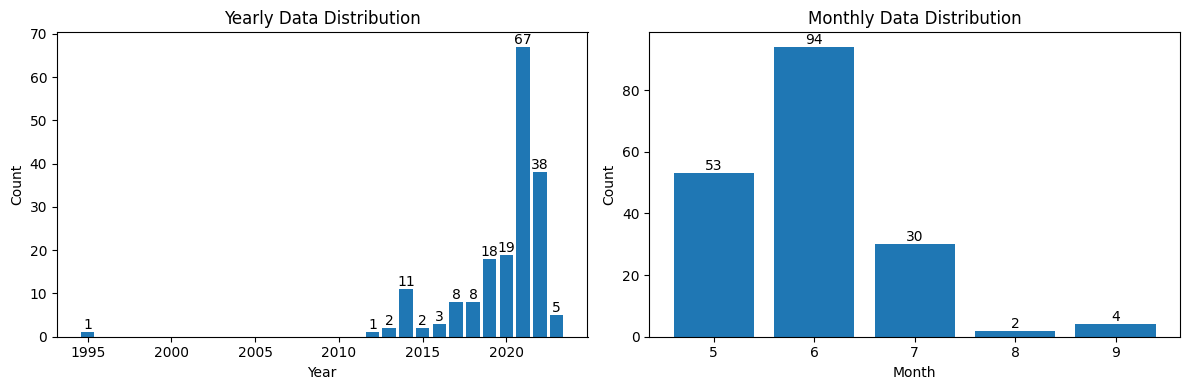

In [11]:
plot_data_distribution(gdf)

The data from 1995 is very sparse, with significant gaps compared to other years, and the months of August and September also have limited samples and exhibit different seasonal characteristics compared to other periods. Excluding this data could contribute to improving the stability and predictive power of the model.

However, it's important to note that excluding data may enhance the model's generalization ability, but it could also lead to the loss of valuable information relevant to the research objectives. Therefore, such decisions should be made with careful consideration.

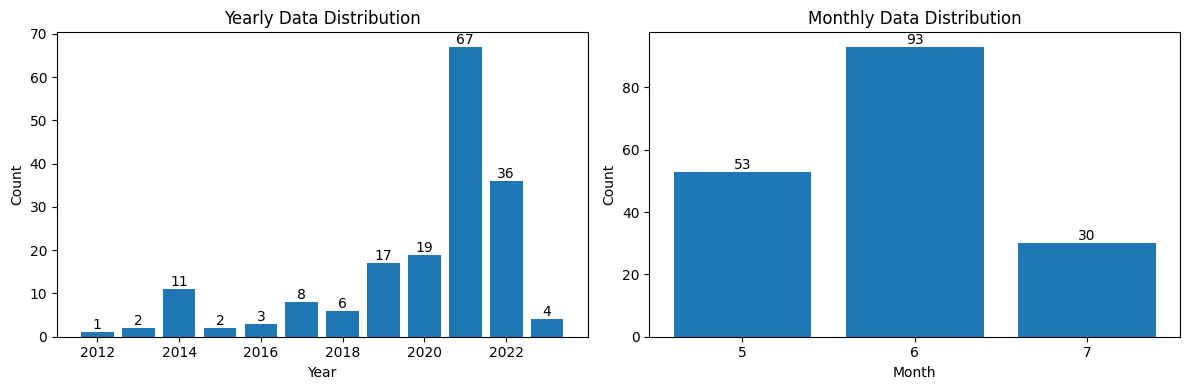

In [12]:
# Filtering data by year and month
filtered_gdf = gdf[
    (~gdf['year'].eq(1995)) &
    (~gdf['month'].between(8, 9))
]

# Visualize the filtered data distribution
plot_data_distribution(filtered_gdf)

Additionally, the use of a heatmap allows us to quickly grasp the frequency of species occurrence by year and month, providing an intuitive visualization of the temporal changes and patterns within the data.

In [13]:
# Yearly and monthly data distribution heatmap
def plot_heatmap(gdf, h_size=8):

    statistics = gdf.groupby(["month", "year"]).size().unstack(fill_value=0)

    # Heatmap
    plt.figure(figsize=(h_size, h_size-6))
    heatmap = plt.imshow(statistics.values, cmap="YlOrBr", origin="upper", aspect="auto")

    # Display values above each pixel
    for i in range(len(statistics.index)):
        for j in range(len(statistics.columns)):
            plt.text(j, i, statistics.values[i, j], ha="center", va="center", color="black")

    plt.colorbar(heatmap, label="Count")
    plt.title("Monthly Species Count by Year")
    plt.xlabel("Year")
    plt.ylabel("Month")
    plt.xticks(range(len(statistics.columns)), statistics.columns)
    plt.yticks(range(len(statistics.index)), statistics.index)
    plt.tight_layout()
    plt.savefig('heatmap_plot.png')
    plt.show()
    print(gdf.groupby(["month", "year"]).size().unstack(fill_value=0))  # Display the data statistics

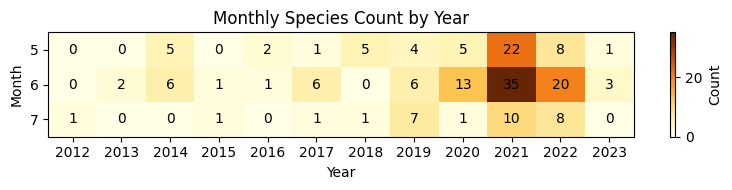

year   2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  2023
month                                                                        
5         0     0     5     0     2     1     5     4     5    22     8     1
6         0     2     6     1     1     6     0     6    13    35    20     3
7         1     0     0     1     0     1     1     7     1    10     8     0


In [14]:
plot_heatmap(filtered_gdf)

Now, the filtered GeoDataFrame is converted into a Google Earth Engine object.

In [15]:
# Convert GeoDataFrame to Earth Engine object
data_raw = geemap.geopandas_to_ee(filtered_gdf)

Next, we will define the raster pixel size of the SDM results as 1km resolution.

In [16]:
# Spatial resolution setting (meters)
GrainSize = 1000

When multiple occurrence points are present within the same 1km resolution raster pixel, there is a high likelihood that they share the same environmental conditions at the same geographic location. Using such data directly in the analysis can introduce bias into the results.

In other words, we need to limit the potential impact of geographic sampling bias. To achieve this, we will retain only one location within each 1km pixel and remove all others, allowing the model to more objectively reflect the environmental conditions.

In [17]:
def remove_duplicates(data, GrainSize):
    # Select one occurrence record per pixel at the chosen spatial resolution (1km)
    random_raster = ee.Image.random().reproject('EPSG:4326', None, GrainSize)
    rand_point_vals = random_raster.sampleRegions(collection=ee.FeatureCollection(data), scale=10, geometries=True)
    return rand_point_vals.distinct('random')

Data = remove_duplicates(data_raw, GrainSize)

# Before selection and after selection
print('Original data size:', data_raw.size().getInfo())
print('Final data size:', Data.size().getInfo())

Original data size: 176
Final data size: 111


The visualization of geographic sampling bias before preprocessing (blue) and after preprocessing (red) is shown below. To facilitate comparison, the map has been centered on an area with a high concentration of Fairy pitta occurrence coordinates.